In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
print(os.listdir("../input"))
from time import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
import pandas
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets.samples_generator import (make_blobs,
                                                make_circles,
                                                make_moons)
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score


from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
from sklearn.model_selection import train_test_split


import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics.cluster import completeness_score
from sklearn.metrics import confusion_matrix

['diabetic_data.csv']


Using TensorFlow backend.


In [2]:
data = pd.read_csv("../input/diabetic_data.csv")
data.head()
data.isna().sum()

encounter_id                0
patient_nbr                 0
race                        0
gender                      0
age                         0
weight                      0
admission_type_id           0
discharge_disposition_id    0
admission_source_id         0
time_in_hospital            0
payer_code                  0
medical_specialty           0
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
diag_1                      0
diag_2                      0
diag_3                      0
number_diagnoses            0
max_glu_serum               0
A1Cresult                   0
metformin                   0
repaglinide                 0
nateglinide                 0
chlorpropamide              0
glimepiride                 0
acetohexamide               0
glipizide                   0
glyburide                   0
tolbutamide                 0
pioglitazo

In [3]:
data.describe()

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,1.017660e+05,1.017660e+05,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,1.652016e+08,5.433040e+07,2.024006,3.715642,5.754437,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,1.026403e+08,3.869636e+07,1.445403,5.280166,4.064081,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,8.496119e+07,2.341322e+07,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.523890e+08,4.550514e+07,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,2.302709e+08,8.754595e+07,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,4.438672e+08,1.895026e+08,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


In [4]:
data.drop(['encounter_id', 'patient_nbr', 'weight','medical_specialty', 'payer_code','admission_source_id' ], axis=1, inplace= True)

In [5]:
data['gender'].value_counts()

Female             54708
Male               47055
Unknown/Invalid        3
Name: gender, dtype: int64

In [6]:
data = data[data.gender != 'Unknown/Invalid']

In [7]:
data = data[(data.discharge_disposition_id != 11) & (data.discharge_disposition_id != 19) & (data.discharge_disposition_id != 20) & (data.discharge_disposition_id != 21) & (data.discharge_disposition_id != 7) ]

In [8]:
data = data[(data.diag_1 != '?') | (data.diag_2 != '?') | (data.diag_3 != '?')]


In [9]:
data.drop(['chlorpropamide','acetohexamide', 'tolbutamide', 'rosiglitazone', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
       'glyburide-metformin', 'glipizide-metformin','glimepiride-pioglitazone', 'metformin-rosiglitazone','metformin-pioglitazone'],axis=1, inplace= True)

In [10]:
data.drop(['diag_1','diag_2','diag_3'], axis=1, inplace= True)

In [11]:
data.race.value_counts()

Caucasian          74418
AfricanAmerican    18744
?                   2225
Hispanic            2001
Other               1471
Asian                628
Name: race, dtype: int64

In [12]:
data["Race"]= data["race"].map(lambda x:'NA' if x=='?' else x)
data.drop(['race'], axis=1, inplace= True)

In [13]:
def get_fn(row):
    if row['admission_type_id']==1 or row['admission_type_id']==2 or row['admission_type_id']==7 :
        return "Non ELective"
    elif row['admission_type_id']==3 or row['admission_type_id']==4:
        return "Elective"
    else :
        return "NA"
data['admission_type']= data.apply(get_fn,axis=1)
data.drop(['admission_type_id'], axis=1, inplace= True)

In [14]:
data.readmitted.value_counts()

NO     52896
>30    35324
<30    11267
Name: readmitted, dtype: int64

In [15]:
def fn(x):
    if x =='NO' or x=='>30':
        return 0
    else :
        return 1
data['readmit']= data['readmitted'].map(fn)
data.drop(['readmitted'], axis=1, inplace= True)

In [16]:
data['A1Cresult'].value_counts()

None    82781
>8       8056
Norm     4894
>7       3756
Name: A1Cresult, dtype: int64

In [17]:
def fun(z):
    if z =='None' or z=='Norm':
        return 1
    else :
        return 0
data['A1C']= data['A1Cresult'].map(fun)
data.drop(['A1Cresult'], axis=1, inplace= True)

In [18]:
def gt_ag(a):
    if a =='[0-10)' or a=='[10-20)' or a=='[20-30)':
        return 'young'
    elif a =='[30-40)' or a=='[40-50)' or a=='[50-60)':
        return 'mid'
    else:
        return'old'
data['Age']= data['age'].map(gt_ag)
data.drop(['age'], axis=1, inplace= True)

In [19]:
data['max_glu_serum'].value_counts()

None    94304
Norm     2553
>200     1431
>300     1199
Name: max_glu_serum, dtype: int64

In [20]:
data['max_glu_serum']=data['max_glu_serum'].replace('None',0)
data['max_glu_serum']=data['max_glu_serum'].replace('Norm',0)
data['max_glu_serum']=data['max_glu_serum'].replace('>200',1)
data['max_glu_serum']=data['max_glu_serum'].replace('>300',1)

In [21]:
def dp_id(a):
    if a ==6 or a==8 or a==9 or a==13 or a==1:
        return 'Discharged Home'
    elif a==18 or a ==25 or a==26 :
        return 'NA'
    else:
        return'Discharged/Transferred'
data['discharge']= data['discharge_disposition_id'].map(dp_id)
data.drop(['discharge_disposition_id'], axis=1, inplace= True)

In [22]:
data.head()

,gender,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_glu_serum,metformin,repaglinide,nateglinide,glimepiride,glipizide,glyburide,pioglitazone,acarbose,insulin,change,diabetesMed,Race,admission_type,readmit,A1C,Age,discharge
0,Female,1,41,0,1,0,0,0,1,0,No,No,No,No,No,No,No,No,No,No,No,Caucasian,NA,0,1,young,NA
1,Female,3,59,0,18,0,0,0,9,0,No,No,No,No,No,No,No,No,Up,Ch,Yes,Caucasian,Non ELective,0,1,young,Discharged Home
2,Female,2,11,5,13,2,0,1,6,0,No,No,No,No,Steady,No,No,No,No,No,Yes,AfricanAmerican,Non ELective,0,1,young,Discharged Home
3,Male,2,44,1,16,0,0,0,7,0,No,No,No,No,No,No,No,No,Up,Ch,Yes,Caucasian,Non ELective,0,1,mid,Discharged Home
4,Male,1,51,0,8,0,0,0,5,0,No,No,No,No,Steady,No,No,No,Steady,Ch,Yes,Caucasian,Non ELective,0,1,mid,Discharged Home


In [23]:
data = pd.get_dummies(data=data, columns=['discharge', 'Age','admission_type','Race','change','insulin','glipizide','gender'])

In [24]:
data.head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_glu_serum,metformin,repaglinide,nateglinide,glimepiride,glyburide,pioglitazone,acarbose,diabetesMed,readmit,A1C,discharge_Discharged Home,discharge_Discharged/Transferred,discharge_NA,Age_mid,Age_old,Age_young,admission_type_Elective,admission_type_NA,admission_type_Non ELective,Race_AfricanAmerican,Race_Asian,Race_Caucasian,Race_Hispanic,Race_NA,Race_Other,change_Ch,change_No,insulin_Down,insulin_No,insulin_Steady,insulin_Up,glipizide_Down,glipizide_No,glipizide_Steady,glipizide_Up,gender_Female,gender_Male
0,1,41,0,1,0,0,0,1,0,No,No,No,No,No,No,No,No,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0
1,3,59,0,18,0,0,0,9,0,No,No,No,No,No,No,No,Yes,0,1,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0
2,2,11,5,13,2,0,1,6,0,No,No,No,No,No,No,No,Yes,0,1,1,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0
3,2,44,1,16,0,0,0,7,0,No,No,No,No,No,No,No,Yes,0,1,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1
4,1,51,0,8,0,0,0,5,0,No,No,No,No,No,No,No,Yes,0,1,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1


In [25]:
data = pd.get_dummies(data=data, columns=['metformin','repaglinide','nateglinide','glimepiride','glyburide','pioglitazone','acarbose'])

In [26]:
data['diabetesMed'] = data['diabetesMed'].map({'Yes': 1, 'No': 0})

In [27]:
data.head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_glu_serum,diabetesMed,readmit,A1C,discharge_Discharged Home,discharge_Discharged/Transferred,discharge_NA,Age_mid,Age_old,Age_young,admission_type_Elective,admission_type_NA,admission_type_Non ELective,Race_AfricanAmerican,Race_Asian,Race_Caucasian,Race_Hispanic,Race_NA,Race_Other,change_Ch,change_No,insulin_Down,insulin_No,insulin_Steady,insulin_Up,glipizide_Down,glipizide_No,glipizide_Steady,glipizide_Up,gender_Female,gender_Male,metformin_Down,metformin_No,metformin_Steady,metformin_Up,repaglinide_Down,repaglinide_No,repaglinide_Steady,repaglinide_Up,nateglinide_Down,nateglinide_No,nateglinide_Steady,nateglinide_Up,glimepiride_Down,glimepiride_No,glimepiride_Steady,glimepiride_Up,glyburide_Down,glyburide_No,glyburide_Steady,glyburide_Up,pioglitazone_Down,pioglitazone_No,pioglitazone_Steady,pioglitazone_Up,acarbose_Down,acarbose_No,acarbose_Steady,acarbose_Up
0,1,41,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0
1,3,59,0,18,0,0,0,9,0,1,0,1,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0
2,2,11,5,13,2,0,1,6,0,1,0,1,1,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0
3,2,44,1,16,0,0,0,7,0,1,0,1,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0
4,1,51,0,8,0,0,0,5,0,1,0,1,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0


In [28]:
x = data.drop(['readmit'], axis=1)
y = data['readmit']

In [29]:
scaler = MinMaxScaler(feature_range=[0,1])
x = scaler.fit_transform(x)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [30]:
from sklearn.model_selection import train_test_split
x_train, x_test,y_train,y_test = train_test_split(x,y, test_size=0.3)

In [31]:
x_test.shape, x_train.shape,y_test.shape, y_train.shape

((29847, 66), (69640, 66), (29847,), (69640,))

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

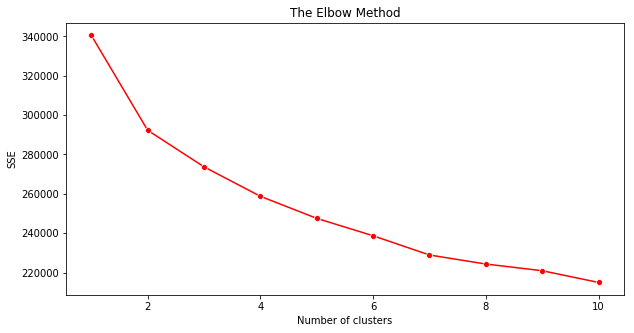

In [32]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42,max_iter = 1000)
    kmeans.fit(x_train)
    # inertia method returns wcss for that model
    wcss.append(kmeans.inertia_)
    plt.figure(figsize=(10,5))

plt.figure(figsize=(10,5))
sns.lineplot(range(1, 11), wcss,marker='o',color='red')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

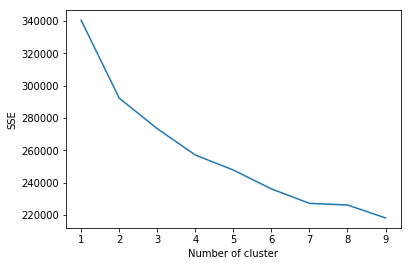

In [33]:
sse = {}
data = pd.DataFrame()
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(x_train)
    data["clusters"] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

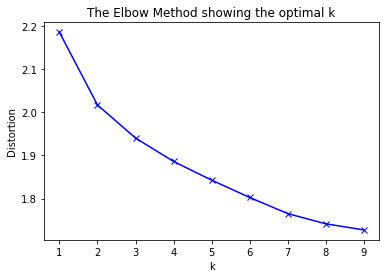

In [34]:
from scipy.spatial.distance import cdist
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters = k, init = 'k-means++', random_state = 42,max_iter = 1000).fit(x_train)
    kmeanModel.fit(x_train)
    distortions.append(sum(np.min(cdist(x_train, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / x_train.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.14842186919731354
Accuracy Score  0.46567494220524674
Completeness Score  0.00022938011775855562
For n_clusters = 3 The average silhouette_score is : 0.0946733769599304
Accuracy Score  0.3917981706704191
Completeness Score  0.0003855834419985039
For n_clusters = 4 The average silhouette_score is : 0.11774941201918776
Accuracy Score  0.23188260126645893
Completeness Score  0.0003208805750889825


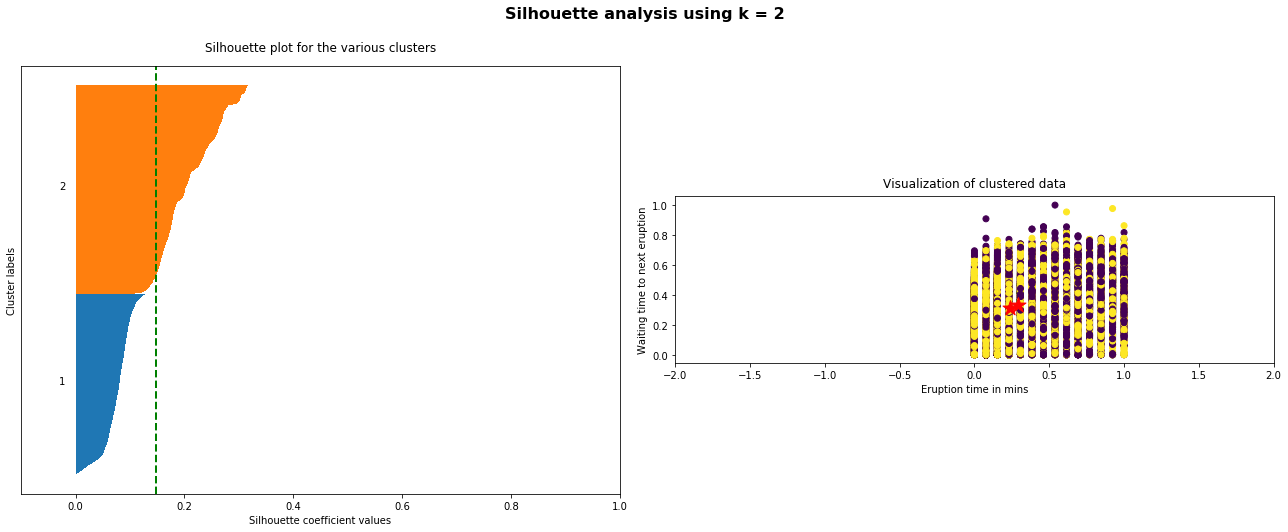

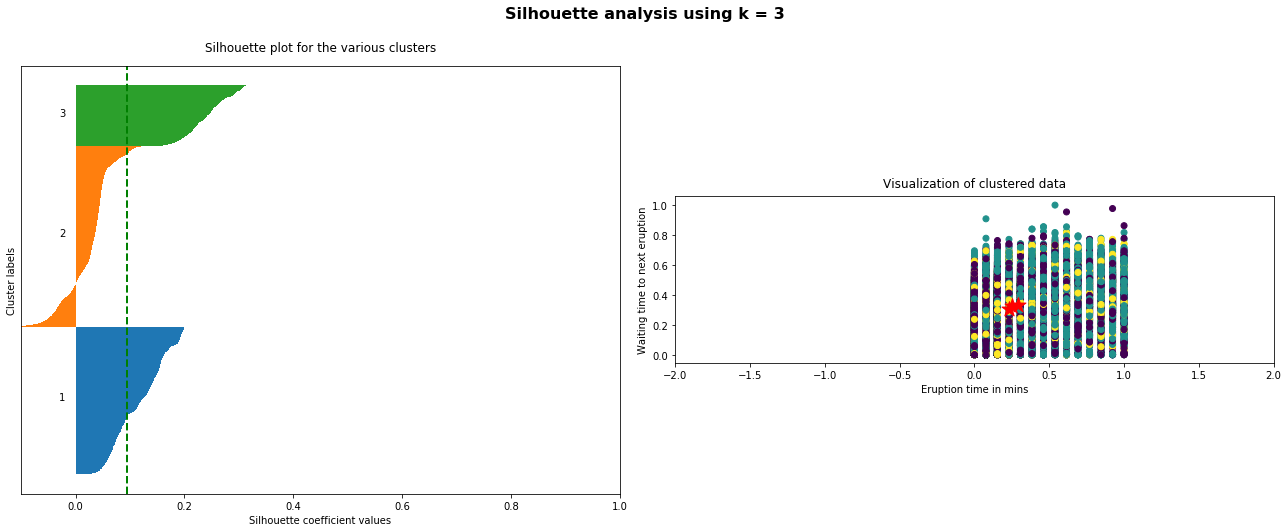

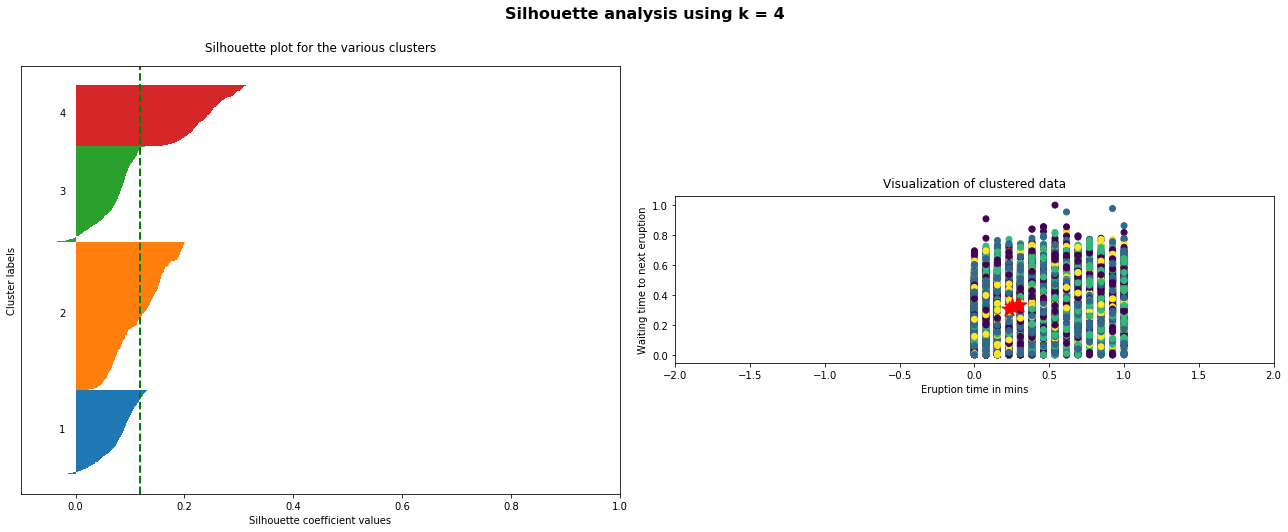

In [35]:
for i, k in enumerate([2, 3, 4]):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    # Run the Kmeans algorithm
    km = KMeans(n_clusters=k, max_iter = 1000)
    labels = km.fit_predict(x_train)
    y_label_test = km.predict(x_test)
    centroids = km.cluster_centers_

    # Get silhouette samples
    silhouette_vals = silhouette_samples(x_train, labels)
    
    
    
    # Silhouette plot
    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
        ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        y_lower += len(cluster_silhouette_vals)

    # Get the average silhouette score and plot it
    avg_score = np.mean(silhouette_vals)
    ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
    ax1.set_yticks([])
    ax1.set_xlim([-0.1, 1])
    ax1.set_xlabel('Silhouette coefficient values')
    ax1.set_ylabel('Cluster labels')
    ax1.set_title('Silhouette plot for the various clusters', y=1.02);
    
    # Scatter plot of data colored with labels
    ax2.scatter(x_train[:, 0], x_train[:, 1], c=labels)
    ax2.scatter(centroids[:, 0], centroids[:, 1], marker='*', c='r', s=250)
    ax2.set_xlim([-2, 2])
    ax2.set_xlim([-2, 2])
    ax2.set_xlabel('Eruption time in mins')
    ax2.set_ylabel('Waiting time to next eruption')
    ax2.set_title('Visualization of clustered data', y=1.02)
    ax2.set_aspect('equal')
    plt.tight_layout()
    plt.suptitle(f'Silhouette analysis using k = {k}',
                 fontsize=16, fontweight='semibold', y=1.05);
   
    silhouette_avg = silhouette_score(x_train, labels)
    print("For n_clusters =", k,
          "The average silhouette_score is :", silhouette_avg)
    #y_label_train = kmeans.labels_
    accurcyscore = accuracy_score(y_test,y_label_test)
    completenessscore =completeness_score(y_test, y_label_test)
    print("Accuracy Score ",accurcyscore)
    print("Completeness Score ",completenessscore)
    #print(confusion_matrix(y_test, y_label_test))

In [36]:
# Applying AutoEncoder

In [37]:
input_data = Input(shape=(66,))
encoded = Dense(60, activation='relu')(input_data)
encoded = Dense(52, activation='relu')(encoded)
encoded = Dense(42, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)
encoded = Dense(22, activation='relu')(encoded)
encoded = Dense(12, activation='relu')(encoded)

encoded = Dense(2, activation='relu')(encoded)

decoded = Dense(22, activation='relu')(encoded)
decoded = Dense(32, activation='relu')(decoded)
decoded = Dense(42, activation='relu')(decoded)
decoded = Dense(52, activation='relu')(decoded)
decoded = Dense(60, activation='relu')(decoded)
decoded = Dense(66, activation='sigmoid')(decoded)

Instructions for updating:
Colocations handled automatically by placer.


In [38]:
autoencoder = Model(input_data, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train,
                epochs=45,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Instructions for updating:
Use tf.cast instead.
Train on 69640 samples, validate on 29847 samples
Epoch 1/45
69640/69640 [==============================] - 4s 55us/step - loss: 0.2953 - val_loss: 0.2483
Epoch 2/45
69640/69640 [==============================] - 2s 35us/step - loss: 0.2325 - val_loss: 0.2322
Epoch 3/45
69640/69640 [==============================] - 2s 35us/step - loss: 0.2221 - val_loss: 0.2246
Epoch 4/45
69640/69640 [==============================] - 2s 35us/step - loss: 0.2147 - val_loss: 0.2210
Epoch 5/45
69640/69640 [==============================] - 2s 35us/step - loss: 0.2106 - val_loss: 0.2176
Epoch 6/45
69640/69640 [==============================] - 2s 35us/step - loss: 0.2074 - val_loss: 0.2185
Epoch 7/45
69640/69640 [==============================] - 2s 35us/step - loss: 0.2032 - val_loss: 0.2089
Epoch 8/45
69640/69640 [==============================] - 2s 35us/step - loss: 0.1991 - val_loss: 0.2014
Epoch 9/45
69640/69640 [==============================] - 2s 3

In [39]:
encoder = Model(input_data, encoded)

In [40]:
reduced_x_train = encoder.predict(x_train)
reduced_x_test = encoder.predict(x_test)


In [41]:
reduced_x_train.shape, reduced_x_test.shape

((69640, 2), (29847, 2))

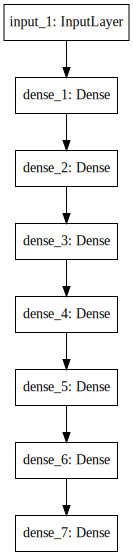

In [42]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(encoder).create(prog='dot', format='svg'))

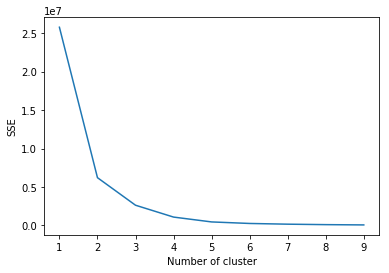

In [43]:
dummy = pd.DataFrame()

sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(reduced_x_train)
    dummy["auto_clusters"] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

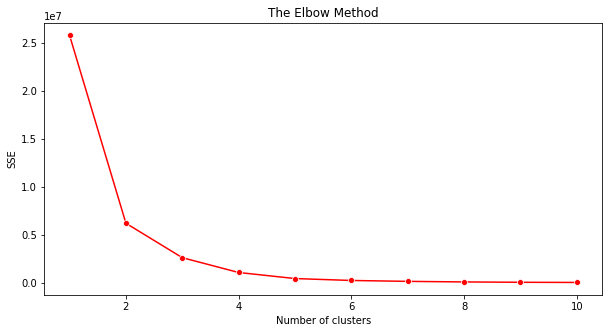

In [44]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42,max_iter = 1000)
    kmeans.fit(reduced_x_train)
    # inertia method returns wcss for that model
    wcss.append(kmeans.inertia_)
    plt.figure(figsize=(10,5))

plt.figure(figsize=(10,5))
sns.lineplot(range(1, 11), wcss,marker='o',color='red')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.8567021
Accuracy Score  0.8225952357020806
Completeness Score  8.244312796924915e-06
For n_clusters = 3 The average silhouette_score is : 0.8303712
Accuracy Score  0.7819211311019533
Completeness Score  0.00013570563224700628
For n_clusters = 4 The average silhouette_score is : 0.78150564
Accuracy Score  0.6911582403591651
Completeness Score  0.0006467405275711152


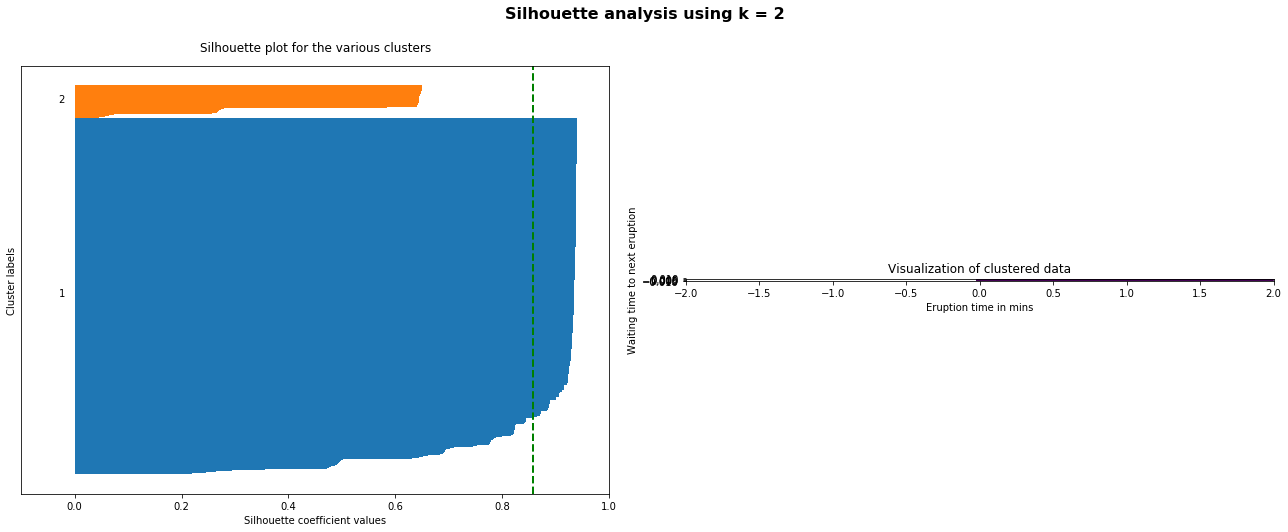

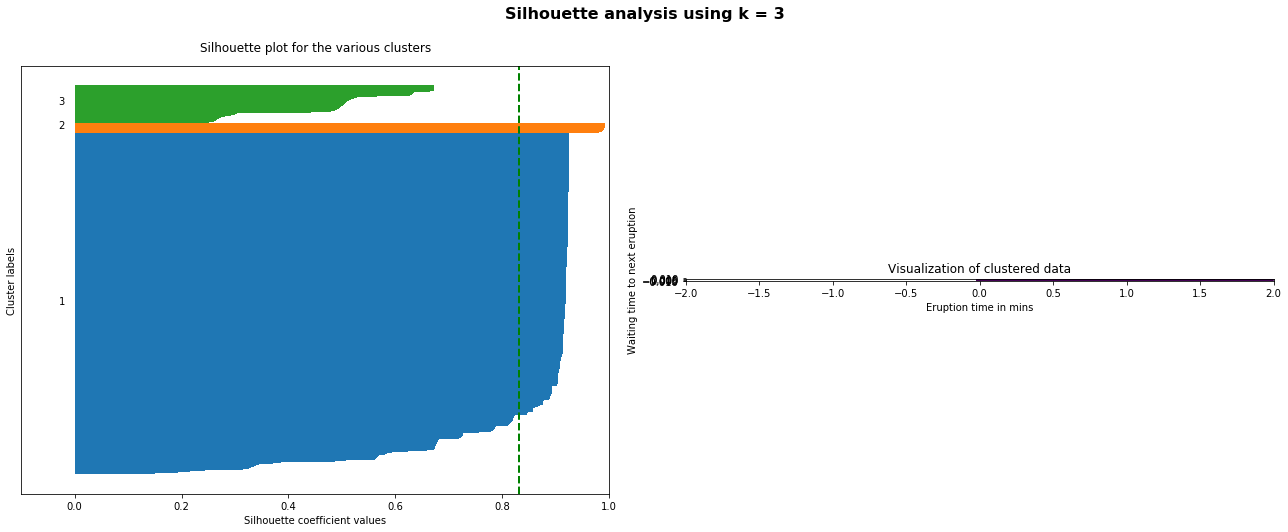

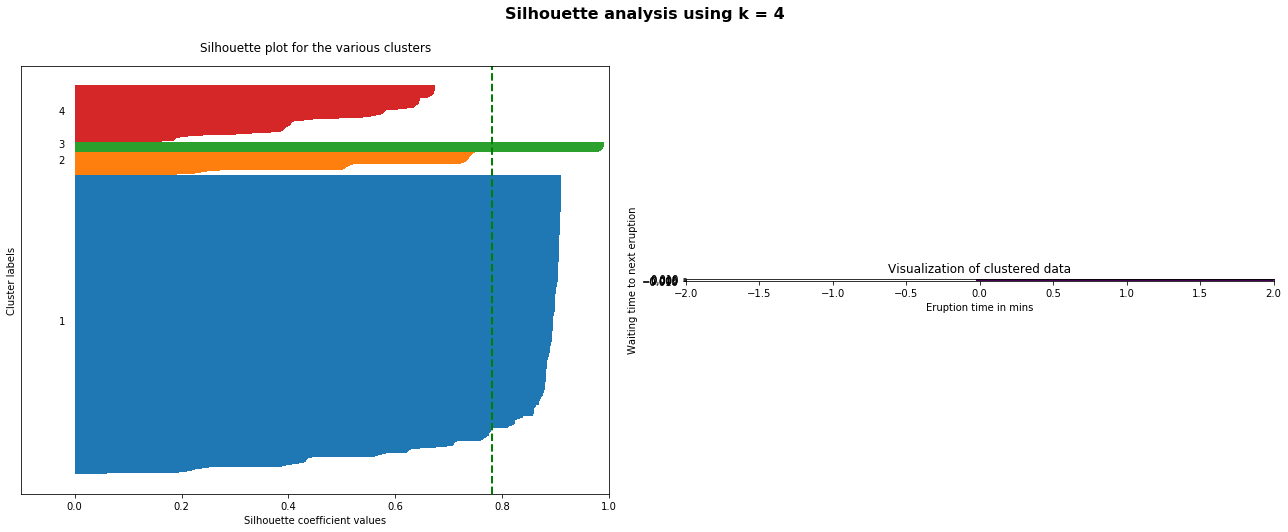

In [45]:
for i, k in enumerate([2, 3, 4]):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    # Run the Kmeans algorithm
    km = KMeans(n_clusters=k, max_iter = 1000)
    labels = km.fit_predict(reduced_x_train)
    y_label_test = km.predict(reduced_x_test)
    centroids = km.cluster_centers_

    # Get silhouette samples
    silhouette_vals = silhouette_samples(reduced_x_train, labels)
    
    
    
    # Silhouette plot
    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
        ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        y_lower += len(cluster_silhouette_vals)

    # Get the average silhouette score and plot it
    avg_score = np.mean(silhouette_vals)
    ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
    ax1.set_yticks([])
    ax1.set_xlim([-0.1, 1])
    ax1.set_xlabel('Silhouette coefficient values')
    ax1.set_ylabel('Cluster labels')
    ax1.set_title('Silhouette plot for the various clusters', y=1.02);
    
    # Scatter plot of data colored with labels
    ax2.scatter(reduced_x_train[:, 0], reduced_x_train[:, 1], c=labels)
    ax2.scatter(centroids[:, 0], centroids[:, 1], marker='*', c='r', s=250)
    ax2.set_xlim([-2, 2])
    ax2.set_xlim([-2, 2])
    ax2.set_xlabel('Eruption time in mins')
    ax2.set_ylabel('Waiting time to next eruption')
    ax2.set_title('Visualization of clustered data', y=1.02)
    ax2.set_aspect('equal')
    plt.tight_layout()
    plt.suptitle(f'Silhouette analysis using k = {k}',
                 fontsize=16, fontweight='semibold', y=1.05);
   
    silhouette_avg = silhouette_score(reduced_x_train, labels)
    print("For n_clusters =", k,
          "The average silhouette_score is :", silhouette_avg)
    #y_label_train = kmeans.labels_
    accurcyscore = accuracy_score(y_test,y_label_test)
    completenessscore =completeness_score(y_test, y_label_test)
    print("Accuracy Score ",accurcyscore)
    print("Completeness Score ",completenessscore)
    #print(confusion_matrix(y_test, y_label_test))

In [46]:
#Using softmax to form clusters

input_data = Input(shape=(66,))
encoded = Dense(60, activation='relu')(input_data)
encoded = Dense(52, activation='relu')(encoded)
encoded = Dense(42, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)
encoded = Dense(22, activation='relu')(encoded)
encoded = Dense(12, activation='relu')(encoded)

encoded = Dense(2, activation='softmax')(encoded)

decoded = Dense(22, activation='relu')(encoded)
decoded = Dense(32, activation='relu')(decoded)
decoded = Dense(42, activation='relu')(decoded)
decoded = Dense(52, activation='relu')(decoded)
decoded = Dense(60, activation='relu')(decoded)
decoded = Dense(66, activation='sigmoid')(decoded)

In [47]:
autoencoder = Model(input_data, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train,
                epochs=45,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 69640 samples, validate on 29847 samples
Epoch 1/45
69640/69640 [==============================] - 5s 67us/step - loss: 0.2952 - val_loss: 0.2761
Epoch 2/45
69640/69640 [==============================] - 3s 37us/step - loss: 0.2572 - val_loss: 0.2486
Epoch 3/45
69640/69640 [==============================] - 3s 37us/step - loss: 0.2319 - val_loss: 0.2333
Epoch 4/45
69640/69640 [==============================] - 3s 36us/step - loss: 0.2244 - val_loss: 0.2218
Epoch 5/45
69640/69640 [==============================] - 3s 37us/step - loss: 0.2168 - val_loss: 0.2205
Epoch 6/45
69640/69640 [==============================] - 3s 36us/step - loss: 0.2130 - val_loss: 0.2223
Epoch 7/45
69640/69640 [==============================] - 3s 37us/step - loss: 0.2091 - val_loss: 0.2159
Epoch 8/45
69640/69640 [==============================] - 3s 37us/step - loss: 0.2052 - val_loss: 0.2113
Epoch 9/45
69640/69640 [==============================] - 3s 40us/step - loss: 0.2018 - val_loss: 0.2193
Epoch

In [48]:
encoder = Model(input_data, encoded)
reduced_x_train = encoder.predict(x_train)
reduced_x_test = encoder.predict(x_test)

In [49]:
predict_clusters = np.argmax(reduced_x_test, axis=1)

In [50]:
predict_clusters

array([1, 0, 0, ..., 1, 1, 0])

In [51]:
reduced_x_test.shape

(29847, 2)

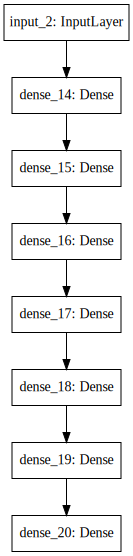

In [52]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(encoder).create(prog='dot', format='svg'))

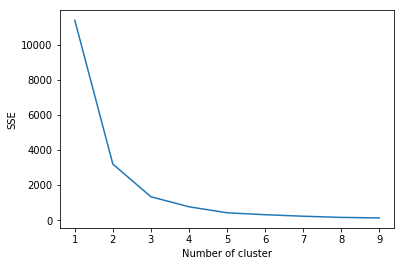

In [53]:
dummy = pd.DataFrame()

sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(reduced_x_train)
    dummy["auto_clusters"] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

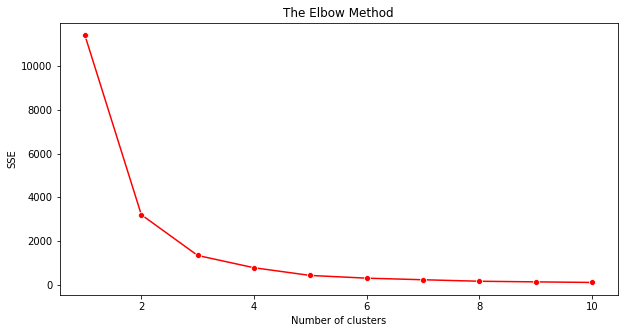

In [54]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42,max_iter = 1000)
    kmeans.fit(reduced_x_train)
    # inertia method returns wcss for that model
    wcss.append(kmeans.inertia_)
    plt.figure(figsize=(10,5))

plt.figure(figsize=(10,5))
sns.lineplot(range(1, 11), wcss,marker='o',color='red')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.6207328
Accuracy Score  0.3864039937012095
Completeness Score  0.0007964786419434629
For n_clusters = 3 The average silhouette_score is : 0.59822756
Accuracy Score  0.3693168492645827
Completeness Score  0.0002834694860747788
For n_clusters = 4 The average silhouette_score is : 0.5846374
Accuracy Score  0.16477367909672663
Completeness Score  0.0009490680333260517


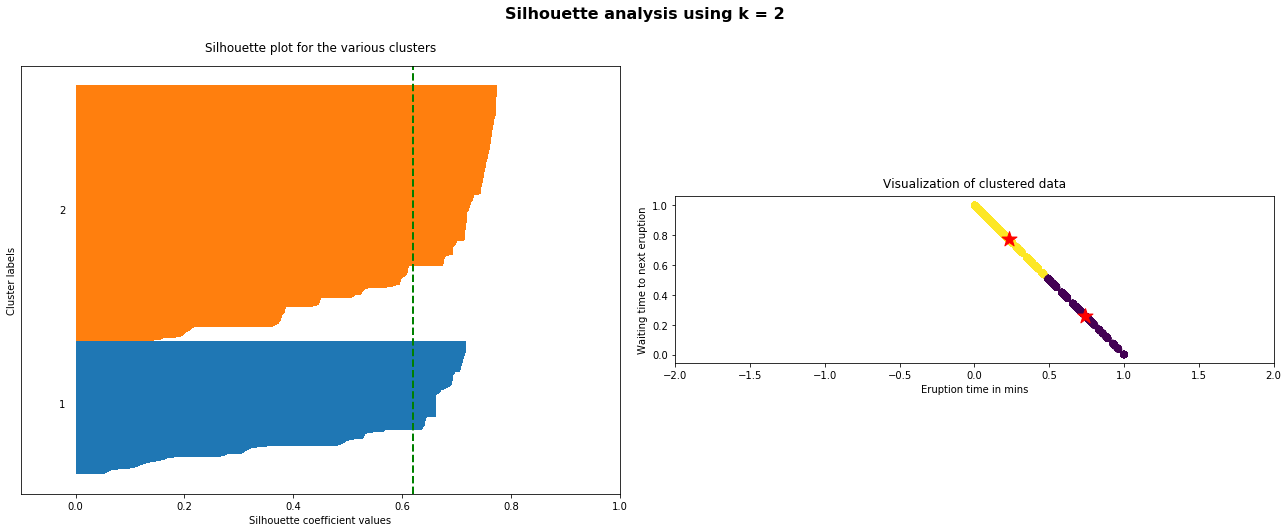

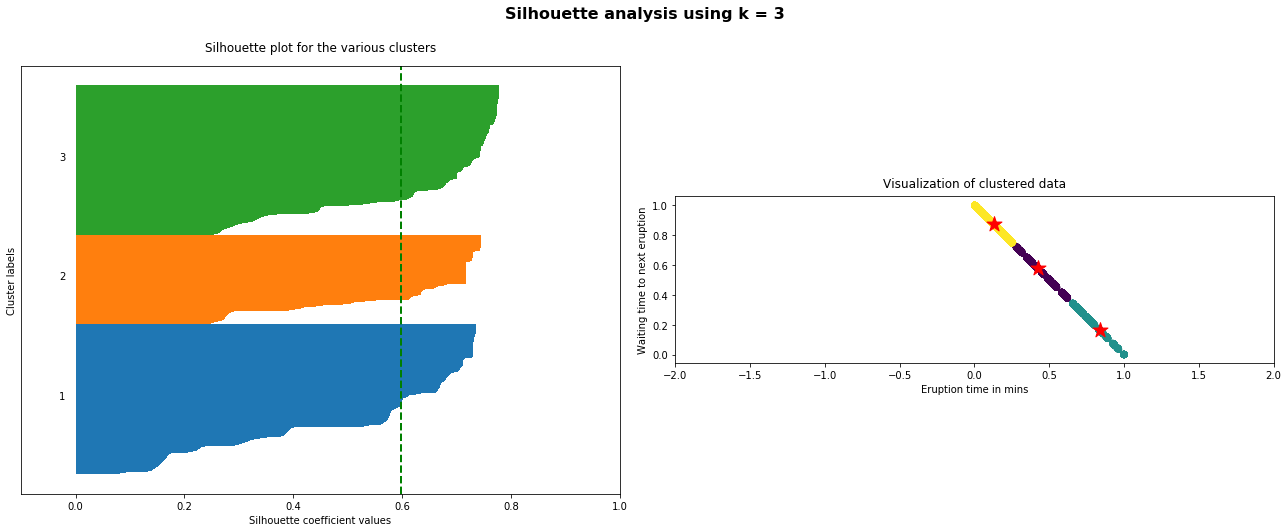

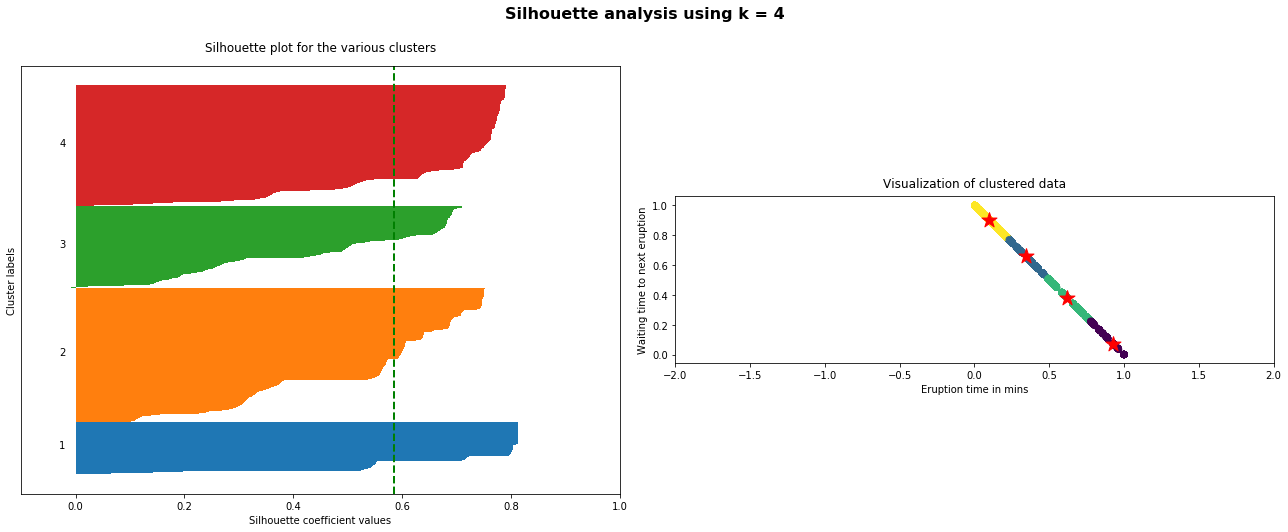

In [55]:
for i, k in enumerate([2, 3, 4]):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    # Run the Kmeans algorithm
    km = KMeans(n_clusters=k, max_iter = 1000)
    labels = km.fit_predict(reduced_x_train)
    y_label_test = km.predict(reduced_x_test)
    centroids = km.cluster_centers_

    # Get silhouette samples
    silhouette_vals = silhouette_samples(reduced_x_train, labels)
    
    
    
    # Silhouette plot
    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
        ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        y_lower += len(cluster_silhouette_vals)

    # Get the average silhouette score and plot it
    avg_score = np.mean(silhouette_vals)
    ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
    ax1.set_yticks([])
    ax1.set_xlim([-0.1, 1])
    ax1.set_xlabel('Silhouette coefficient values')
    ax1.set_ylabel('Cluster labels')
    ax1.set_title('Silhouette plot for the various clusters', y=1.02);
    
    # Scatter plot of data colored with labels
    ax2.scatter(reduced_x_train[:, 0], reduced_x_train[:, 1], c=labels)
    ax2.scatter(centroids[:, 0], centroids[:, 1], marker='*', c='r', s=250)
    ax2.set_xlim([-2, 2])
    ax2.set_xlim([-2, 2])
    ax2.set_xlabel('Eruption time in mins')
    ax2.set_ylabel('Waiting time to next eruption')
    ax2.set_title('Visualization of clustered data', y=1.02)
    ax2.set_aspect('equal')
    plt.tight_layout()
    plt.suptitle(f'Silhouette analysis using k = {k}',
                 fontsize=16, fontweight='semibold', y=1.05);
   
    silhouette_avg = silhouette_score(reduced_x_train, labels)
    print("For n_clusters =", k,
          "The average silhouette_score is :", silhouette_avg)
    #y_label_train = kmeans.labels_
    accurcyscore = accuracy_score(y_test,y_label_test)
    completenessscore =completeness_score(y_test, y_label_test)
    print("Accuracy Score ",accurcyscore)
    print("Completeness Score ",completenessscore)
    #print(confusion_matrix(y_test, y_label_test))